# Fire Damages Area Prediction
This notebook looks to predict the total area of damage caused by a fire. The data is originally found on the UCI Machine Learning Repository/

In [94]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [95]:
fires = pd.read_csv("fires.csv")

fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]
reference = LinearRegression()

In [96]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [97]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


FFMC, DMC, DC, ISI, temp, RH, wind, rain all contain missing values

In [98]:
fires.isnull().sum()

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

Many of the columns have NA values, we will have to do some investigating as to how to deal with them.

In [99]:
fires.describe()

,Unnamed: 0,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,259.000000,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,149.389312,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,130.000000,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,259.000000,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,388.000000,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,517.000000,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [100]:
fires["is_summer"] = np.where(fires["month"].isin(["jun", "jul", "aug"]), 1, 0)
fires["is_summer"].value_counts()
fires.drop(["Unnamed: 0", "X", "Y", "month", "day"], axis=1, inplace=True)

Lets try using a KNNImputer to fill in the missing data.

In [101]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputer.fit_transform(fires)
fires_imp = pd.DataFrame(
    imputer.fit_transform(fires),
    columns=fires.columns,
    index=fires.index
)

In [102]:
fires_imp.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,is_summer
0,86.2,26.2,94.300000,5.1,16.6,51.0,6.700000,0.0,0.0,0.0
1,90.6,80.2,669.100000,6.7,18.0,33.0,0.900000,0.0,0.0,0.0
2,90.6,43.7,470.833333,6.7,14.6,33.0,1.300000,0.0,0.0,0.0
3,91.7,33.3,77.500000,9.0,8.3,97.0,4.000000,0.2,0.0,0.0
4,89.3,51.3,102.200000,9.6,11.4,99.0,4.333333,0.0,0.0,0.0


In [103]:
fires_imp.isna().sum()

FFMC         0
DMC          0
DC           0
ISI          0
temp         0
RH           0
wind         0
rain         0
area         0
is_summer    0
dtype: int64

<Axes: >

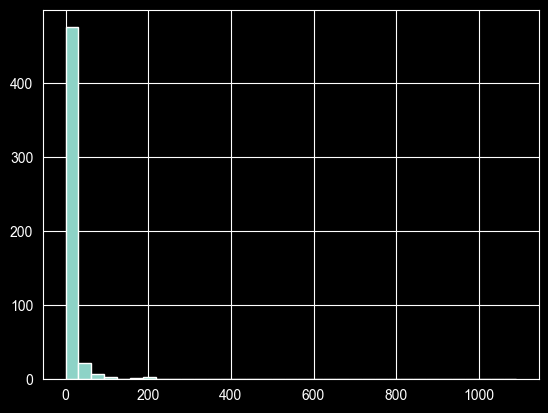

In [104]:
fires_imp["area"].hist(bins=35)

<Axes: >

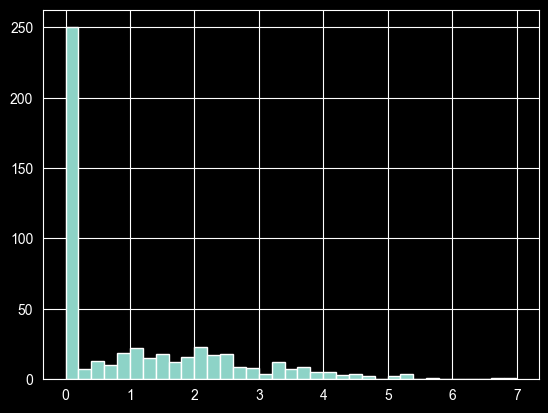

In [105]:
fires["area_log"] = np.log1p(fires["area"])
fires["area_log"].hist(bins=35)

Using a log version of area gives us still a very right skewed variable, but it is a bit better than it being non logged.

In [106]:
fires_imp.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,is_summer
0,86.2,26.2,94.300000,5.1,16.6,51.0,6.700000,0.0,0.0,0.0
1,90.6,80.2,669.100000,6.7,18.0,33.0,0.900000,0.0,0.0,0.0
2,90.6,43.7,470.833333,6.7,14.6,33.0,1.300000,0.0,0.0,0.0
3,91.7,33.3,77.500000,9.0,8.3,97.0,4.000000,0.2,0.0,0.0
4,89.3,51.3,102.200000,9.6,11.4,99.0,4.333333,0.0,0.0,0.0


<Axes: >

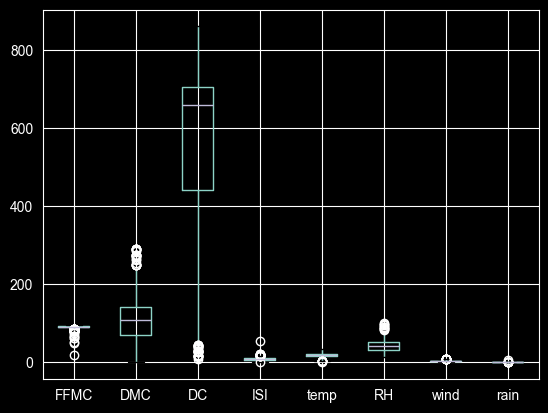

In [107]:
fires_imp.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])

In [108]:
for col in fires_imp.columns[0:8]:
    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (iqr * 1.5)
    upper_bound = quartiles[2] + (iqr * 1.5)
    outliers = sum((fires_imp[col] < lower_bound) | (fires_imp[col] > upper_bound))

    print(f"column: {col} has {outliers} outliers")

column: FFMC has 0 outliers
column: DMC has 0 outliers
column: DC has 0 outliers
column: ISI has 0 outliers
column: temp has 0 outliers
column: RH has 0 outliers
column: wind has 0 outliers
column: rain has 0 outliers


Looks like we are alright with outliers and can proceed.

In [109]:
fires_imp.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,is_summer
0,86.2,26.2,94.300000,5.1,16.6,51.0,6.700000,0.0,0.0,0.0
1,90.6,80.2,669.100000,6.7,18.0,33.0,0.900000,0.0,0.0,0.0
2,90.6,43.7,470.833333,6.7,14.6,33.0,1.300000,0.0,0.0,0.0
3,91.7,33.3,77.500000,9.0,8.3,97.0,4.000000,0.2,0.0,0.0
4,89.3,51.3,102.200000,9.6,11.4,99.0,4.333333,0.0,0.0,0.0


In [111]:
fires_imp.drop("area", axis=1, inplace=True)

In [112]:
fires_imp.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,is_summer
0,86.2,26.2,94.300000,5.1,16.6,51.0,6.700000,0.0,0.0
1,90.6,80.2,669.100000,6.7,18.0,33.0,0.900000,0.0,0.0
2,90.6,43.7,470.833333,6.7,14.6,33.0,1.300000,0.0,0.0
3,91.7,33.3,77.500000,9.0,8.3,97.0,4.000000,0.2,0.0
4,89.3,51.3,102.200000,9.6,11.4,99.0,4.333333,0.0,0.0


In [115]:
from sklearn.preprocessing import StandardScaler

binary_cols = ["is_summer"]
scale_cols = fires_imp.columns.difference(binary_cols)

scaler = StandardScaler()
df_scaled = fires_imp.copy()
df_scaled[scale_cols] = scaler.fit_transform(fires_imp[scale_cols])
df_scaled.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,is_summer
0,-0.814538,-1.338227,-1.856766,-0.860187,-0.401978,0.418814,1.520379,-0.073268,0.0
1,-0.011821,-0.485458,0.506489,-0.508736,-0.157358,-0.716045,-1.766261,-0.073268,0.0
2,-0.011821,-1.061867,-0.308673,-0.508736,-0.751437,-0.716045,-1.539596,-0.073268,0.0
3,0.188858,-1.226104,-1.925838,-0.003526,-1.852231,3.319008,-0.009609,0.603155,0.0
4,-0.248987,-0.941847,-1.824286,0.128267,-1.310570,3.445104,0.179279,-0.073268,0.0


Scale the numerical predictors, did not scale the one binary predictor.

In [116]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["area_log"]

sfs_model1 = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model1,
                                     n_features_to_select=2,
                                     direction="forward")
forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4,
                                     direction="forward")
forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                     n_features_to_select=6,
                                     direction="forward")

forward2.fit(df_scaled, y)
forward4.fit(df_scaled, y)
forward6.fit(df_scaled, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'ISI' 'wind']
Features selected in 6 feature model: ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'is_summer']


In [117]:
backward2 = SequentialFeatureSelector(estimator=sfs_model1,
                                     n_features_to_select=2,
                                     direction="backward")
backward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4,
                                     direction="backward")
backward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                     n_features_to_select=6,
                                     direction="backward")

backward2.fit(df_scaled, y)
backward4.fit(df_scaled, y)
backward6.fit(df_scaled, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'ISI' 'wind']
Features selected in 6 feature model: ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'is_summer']


In [122]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

ridge = RidgeCV(alphas=np.linspace(1, 10000, 1000))
lasso = LassoCV(alphas=np.linspace(1, 10000, 1000))

ridge.fit(df_scaled, y)
lasso.fit(df_scaled, y)

print("Ridge optimal alpha:", ridge.alpha_)
print("Lasso optimal alpha:", lasso.alpha_)

print("Ridge Coeficients:", ridge.coef_)
print("Lasso Coeficients:", lasso.coef_)

Ridge optimal alpha: 1112.0
Lasso optimal alpha: 10000.0
Ridge Coeficients: [ 0.0132647   0.02305181  0.0258399  -0.01311068  0.01067192 -0.01841471
  0.03288963  0.00945238 -0.01766117]
Lasso Coeficients: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [123]:
from sklearn.model_selection import cross_val_score

reference_cv = cross_val_score(reference, df_scaled[["wind", "temp"]], y, cv=5, scoring="neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, df_scaled,y, cv=5, scoring="neg_mean_squared_error")


In [124]:
print("Reference: ", np.mean(reference_cv))
print("Ridge: ", np.mean(ridge_cv))

Reference:  -2.210870792916156
Ridge:  -2.30379917975264
